# I PageRanked the NBA
(This was written on Jan. 20th, 2016 and all results and conclusions are based on the state of the NBA season at that time.)

**Not all wins are created equal.**

Beating the 2015-16 Golden State Warriors is a different task than beating the 2015-16 Los Angeles Lakers. So what if we weighted victories differently?

Suppose we weighed victories by the number of wins of the defeated team. That means beating teams with more wins is more valueable!

NBA Power Rankings are coming out in full force as the season moves through the halfway point. I wanted to do my own power ranking with analysis to back it up. While thinking about rankings with weighted wins, I encountered an iterative problem: the Warriors beat the Lakers but the Lakers beat the Pistons but the Pistons beat the Warriors! If the value of a team is based on the number of wins of the team they beat, this value is a never-ending, always-increasing cycle. But I recognized this same problem in determining relevance in websites based on links: a website is valuable based on the value of the websites linking to it. Well, that sounds like our power ranking definition: the power of a team is based on the power of the team it beats. So I decided to approach the problem like a web search problem. Who is really good at web search? Google. And what do they do to solve this? Google uses [PageRank](https://en.wikipedia.org/wiki/PageRank). So I borrowed it to do an NBA Power Ranking.

The data is obtained from [Basketball-Reference's 2015-16 Schedule](http://www.basketball-reference.com/leagues/NBA_2016_games.html?lid=header_seasons). I manually copied-and-pasted the CSV version and saved it. I removed the unused columns and all the unplayed games.

In [183]:
import pandas as pd

# Load Schedule
schedule = pd.read_csv('2015_16_Schedule.csv',
                       header=0)
schedule = schedule.drop(['Unnamed: 2', 'Unnamed: 7', 'Notes'], axis=1)
schedule = schedule.dropna()

## Creating the NBA Graph

We create a adjacency matrix for the graph of NBA using the teams as nodes and the wins as weighted, directed edges. So a directed edge of weight 2 from the Warriors to the Lakers means the Warriors have beat the Lakers twice.

In [184]:
import numpy as np

# Create Records Matrix
teams = pd.read_csv('teams.csv', names=['teams'])
teams = teams['teams'].tolist()
teams = [team.strip() for team in teams]
n_teams = len(teams)
records = pd.DataFrame(np.zeros((n_teams,n_teams)),
                       columns=teams,
                       index=teams)
# Compute Records
for index, game in schedule.iterrows():
    hometeam = game['Home/Neutral']
    visitor = game['Visitor/Neutral']
    if hometeam == visitor:
        continue

    if int(game['PTS.1']) > int(game['PTS']):
        # Home Team won
        records.at[hometeam, visitor] += 1
    else:
        # Visiting Team won
        records.at[visitor, hometeam] += 1

## Eigenvector Centrality

At its core, PageRank solves for the principle eigenvector of the adjacency matrix. We call the concept [eigenvector centrality](https://en.wikipedia.org/wiki/Centrality#Eigenvector_centrality) because an eigenvector will assign relative values to nodes based on the values of its connections. The final values will be used to rank the nodes in importance. Below is the basic approach of computing the eigenvalue using the [power iteration](https://en.wikipedia.org/wiki/Power_iteration) method.

In [185]:
import math

def centrality_scores(G, stop_count=100):
    n = G.shape[1]
    e = np.ones(n)/math.sqrt(n)
    g = G.as_matrix()
    for _ in xrange(stop_count):
        e = np.dot(g,e)
        e /= np.linalg.norm(e)
    return pd.Series(e, index=G.index, name=['score'])

## Katz Centrality

One method that goes beyond this is [Katz Centrality](https://en.wikipedia.org/wiki/Katz_centrality). Katz Centrality also considers the importance of a node by counting *all* paths to it (not just immediate neighbors) yet the value of a path is attenuated by its distance from the node. For example, A -> B and A -> D -> C -> B are both paths to B but the second path is less valuable because it's made of 3 edges. The algorithm wil attenuate by specifying a factor, alpha, that's raised to the power of edge lengths of the path.

The implementation is based on the one from the NetworkX project (BSD licensed too) with copyrights by:
      
      Aric Hagberg <hagberg@lanl.gov>
      Dan Schult <dschult@colgate.edu>
      Pieter Swart <swart@lanl.gov>

In [186]:
def katz_centrality(G, alpha=0.1):
    n = G.shape[0]
    b = np.ones((n,1.0))
    centrality = np.linalg.solve( np.eye(n,n) - (alpha * G) , b)
    norm = np.sign(sum(centrality)) * np.linalg.norm(centrality)
    scores = [c[0]/norm[0] for c in centrality]
    return pd.Series(scores, index=G.index, name=['score'])

## PageRank

Last but not least, PageRank. PageRank will calculate, for a node, the percentage that a random walk starting from any other node will end up at the node. Furthermore, there is a dampening factor used to constrain the random walk. This is like another way to attenuate long paths as a result of long exploration. Effectively, it values edges from closer neighboring nodes.

The implementation is based on the one from the NetworkX project (BSD licensed too) with copyrights by:
      
      Aric Hagberg <hagberg@lanl.gov>
      Dan Schult <dschult@colgate.edu>
      Pieter Swart <swart@lanl.gov>

In [187]:
def pagerank(G, index, alpha=0.85, max_iter=100, tol=1e-10):
    n = G.shape[0]
    X = G.copy()
    incoming_counts = np.asarray(G.sum(axis=1)).ravel()

    for i in incoming_counts.nonzero()[0]:
        G.data[G.indptr[i]:G.indptr[i + 1]] *= 1.0 / incoming_counts[i]
    dangle = np.asarray(np.where(G.sum(axis=1) == 0, 1.0 / n, 0)).ravel()

    scores = np.ones(n, dtype=np.float32) / n  # initial guess
    for i in range(max_iter):
        prev_scores = scores
        scores = (alpha * (scores * G + np.dot(dangle, prev_scores))
                  + (1 - alpha) * prev_scores.sum() / n)
        # check convergence: normalized l_inf norm
        scores_max = np.abs(scores).max()
        if scores_max == 0.0:
            scores_max = 1.0
        err = np.abs(scores - prev_scores).max() / scores_max
        if err < n * tol:
            return pd.Series(scores, index=index, name=['score'])

    return pd.Series(scores, index=index, name=['score'])

## Eigenvector Centrality Results

In [188]:
rank = centrality_scores(records)
rank.sort(ascending=False)
print rank

Golden State Warriors     0.320439
San Antonio Spurs         0.293995
Oklahoma City Thunder     0.243888
Cleveland Cavaliers       0.223047
Toronto Raptors           0.218515
Chicago Bulls             0.214466
Los Angeles Clippers      0.209885
Atlanta Hawks             0.206417
Dallas Mavericks          0.195671
Miami Heat                0.194414
Memphis Grizzlies         0.192992
Indiana Pacers            0.192104
Detroit Pistons           0.190415
Houston Rockets           0.183472
Boston Celtics            0.182879
Washington Wizards        0.178431
New York Knicks           0.170497
Charlotte Hornets         0.166429
Milwaukee Bucks           0.162197
Sacramento Kings          0.149430
Portland Trail Blazers    0.147289
Orlando Magic             0.144203
Utah Jazz                 0.141260
Denver Nuggets            0.128917
New Orleans Pelicans      0.125596
Phoenix Suns              0.105573
Brooklyn Nets             0.100305
Minnesota Timberwolves    0.095584
Los Angeles Lakers  

## Katz Centrality Results

In [189]:
rank = katz_centrality(records)
rank.sort(ascending=False)
print rank

Golden State Warriors     0.392627
San Antonio Spurs         0.334972
Oklahoma City Thunder     0.242028
Toronto Raptors           0.238462
Chicago Bulls             0.235002
Atlanta Hawks             0.214440
Cleveland Cavaliers       0.213662
Los Angeles Clippers      0.200484
Dallas Mavericks          0.194105
Detroit Pistons           0.193990
Indiana Pacers            0.193942
Miami Heat                0.192266
Washington Wizards        0.191715
Boston Celtics            0.188741
Memphis Grizzlies         0.182001
Houston Rockets           0.167708
Charlotte Hornets         0.165306
New York Knicks           0.155345
Milwaukee Bucks           0.150180
Sacramento Kings          0.130500
Portland Trail Blazers    0.100803
New Orleans Pelicans      0.095528
Utah Jazz                 0.095409
Orlando Magic             0.090400
Denver Nuggets            0.084243
Brooklyn Nets             0.063511
Phoenix Suns              0.049870
Minnesota Timberwolves    0.027129
Los Angeles Lakers  

## PageRank Results

In [190]:
from scipy import sparse

# We do convert to a sparse matrix because that's what the function expects.
rank = pagerank(sparse.csr_matrix(records.as_matrix()),index=records.index)
rank.sort()
print rank

Golden State Warriors     0.010972
San Antonio Spurs         0.012725
Cleveland Cavaliers       0.017536
Oklahoma City Thunder     0.019422
Los Angeles Clippers      0.022289
Memphis Grizzlies         0.023151
Toronto Raptors           0.025924
Dallas Mavericks          0.026420
Indiana Pacers            0.028118
Orlando Magic             0.029046
Atlanta Hawks             0.029279
Miami Heat                0.029421
Chicago Bulls             0.030338
New York Knicks           0.030940
Charlotte Hornets         0.031022
Detroit Pistons           0.031239
Washington Wizards        0.032193
Boston Celtics            0.032279
Utah Jazz                 0.032845
Houston Rockets           0.034780
Milwaukee Bucks           0.035673
New Orleans Pelicans      0.040957
Denver Nuggets            0.042035
Sacramento Kings          0.042844
Brooklyn Nets             0.044180
Portland Trail Blazers    0.044823
Minnesota Timberwolves    0.051476
Philadelphia 76ers        0.053643
Phoenix Suns        

### Note

Notice that the PageRank scores are given in ascending order. Recall that a team's power ranking comes from the teams it beat or in terms of the graph, directed edges *away from it* since an edge A -> B means team A beat team B. In PageRank, a website's value comes from website that link to it or in terms of the graph, directed edges *to it*. PageRank values incoming edges and so it scores our power ranking in reverse fashion (high scores goes to teams that get pummeled a lot). So we reverse the order for it to make sense in our situation.

## Conclusion

All algorithms agree that the Warriors and the Spurs are the best in the league. The attenuation/dampening presented by Katz + PageRank are valuable attributes of the algorithms because indirect face-offs ("my team beat your team via [Transitive Property](http://www.mathwords.com/t/transitive_property_inequalities.htm)" e.g. Lakers > Pistons and Pistons > Warriors therefore Lakers > Warriors) have little significance to the ranking of teams and most of the time, are simply not true. Distinct matchups between teams are highlighted by their unique attributes that have different effectiveness against other teams. Rankings cannot be simply described by the transitive property. The Katz + PageRank algorithm attenuates/dampens their value in the power ranking calculation, thereby favoring direct matchups.

There are also some weaknesses in this analysis. What these power rankings assume is that each team plays every game at the same level. That means the Warriors team that blew out the Cavs is playing at the same level when they got blown out by the Pistons. This is not true because team/player performance varies from night to night. Or coaching staffs are trying minimizing the risk of injury and fatigue and playing critical players less.

## For Fun: Plot the NBA Network

I plotted the NBA network below. As you can see it's pretty convoluted. There's not much to discern which is why I didn't even label the nodes.

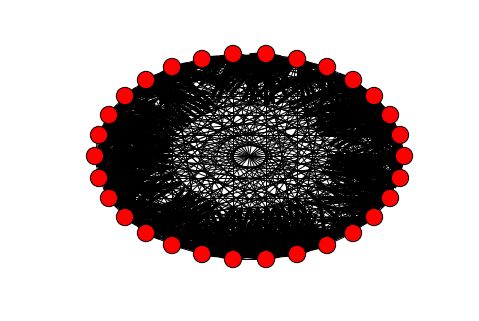

In [191]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt

R = nx.DiGraph(records.as_matrix())
nx.draw_circular(R)
plt.show()

## More Fun: HITS Algorithm

This is another web search algorithm but doesn't make sense in this NBA Power Ranking setting.

The [HITS Algorithm](https://en.wikipedia.org/wiki/HITS_algorithm) was thought up by Jon Kleinberg who noticed that the World Wide Web can be thought of having 2 different types of websites: ones with many links to it (Authorities) and ones with many links to others (Hubs). A web site is a high-quality authority if it has many links from high-quality hubs. A web site is a high-quality hub if it has many link to high-quality authorities. (see the recursive definition again?).

Why doesn't this algorithm make sense for our power ranking?

This goes back to the directed edges. If victories are edges away from a node then defeat are edge to a node. A high-quality authority has many links to it. In the realm of our power rankings, that means a team is a high-quality authority if its gets pummeled a lot. And because a hub's quality is the sum of the high-quality authorities it links to, a team is a high-quality hub if it beats high-quality authorities a.k.a. teams that gets pummeled a lot. A team isn't good if they consistently beat teams that are constantly getting beat!

So here it is below (remember, it's meaningless): 

In [192]:
def HITS2(G, auth, hubs):
    """
    Hyperlink-Induced Topic Search
    Weighted HITS algorithm. Adds weights of edges, not just count of edges.
    G is the graph. Auth and hubs are lists of scores.
    """
    for _ in xrange(100):
        for idx, team in enumerate(G.index):
            # 'G[team] > 0' returns indices of teams that have beat 'team'
            auth[idx] = hubs[G[team] > 0].sum()
        auth = pd.Series(auth.values/np.linalg.norm(auth.values),
                         index=auth.index,
                         name='auth_scores')
        for idx, team in enumerate(G.index):
            # 'G.loc[team] > 0' returns indices of teams that 'team' has beat at least once
            hubs[idx] = auth[G.loc[team] > 0].sum()
        hubs = pd.Series(hubs.values/np.linalg.norm(hubs.values),
                         index=hubs.index,
                         name='hub_scores')
    return auth, hubs

auth = records.sum()
hubs = records.sum(axis=1)
auth, hubs = HITS2(records, auth, hubs)

In [193]:
auth.sort(ascending=False)
print auth

Brooklyn Nets             0.261004
Philadelphia 76ers        0.254143
Phoenix Suns              0.240013
Los Angeles Lakers        0.237207
Portland Trail Blazers    0.233796
Minnesota Timberwolves    0.233535
New Orleans Pelicans      0.210094
Charlotte Hornets         0.204160
Milwaukee Bucks           0.203609
Washington Wizards        0.198395
Denver Nuggets            0.187927
Miami Heat                0.187222
Sacramento Kings          0.184978
Houston Rockets           0.181849
Indiana Pacers            0.178823
Detroit Pistons           0.178135
Dallas Mavericks          0.174600
Utah Jazz                 0.172978
Memphis Grizzlies         0.169446
New York Knicks           0.169333
Boston Celtics            0.157728
Atlanta Hawks             0.156313
Orlando Magic             0.147707
Chicago Bulls             0.133737
Los Angeles Clippers      0.133443
Toronto Raptors           0.130951
Oklahoma City Thunder     0.127077
Cleveland Cavaliers       0.111932
San Antonio Spurs   

In [194]:
hubs.sort(ascending=False)
print hubs

San Antonio Spurs         0.249606
Miami Heat                0.246232
Oklahoma City Thunder     0.238297
Cleveland Cavaliers       0.234669
Golden State Warriors     0.232420
Los Angeles Clippers      0.228179
Dallas Mavericks          0.213076
Memphis Grizzlies         0.212520
Atlanta Hawks             0.201572
Chicago Bulls             0.198735
Boston Celtics            0.195178
New York Knicks           0.194382
Charlotte Hornets         0.193816
Indiana Pacers            0.191361
Detroit Pistons           0.185202
Houston Rockets           0.182801
Toronto Raptors           0.177703
Milwaukee Bucks           0.174155
Orlando Magic             0.167748
Portland Trail Blazers    0.156433
Sacramento Kings          0.149924
Utah Jazz                 0.147086
Washington Wizards        0.144128
Denver Nuggets            0.138901
New Orleans Pelicans      0.129282
Phoenix Suns              0.120421
Minnesota Timberwolves    0.119120
Los Angeles Lakers        0.111764
Brooklyn Nets       